# Quickstart to `pygad`

## Content:

1. loading the snapshot and accessing data
    - 1.1 load a `Snap`
    - 1.2 access blocks and other data
    - 1.3 blocks have units
    - 1.4 sub-snapshots
    - 1.5 dervied blocks
    - 1.6 more on blocks and `UnitArrs`
2. analysis and plotting
    - 2.1 a first look
    - 2.2 finding halos & preparing a zoom
    - 2.3 plotting maps and other stuff
    - 2.4 binning
    - 2.5 quantitative analysis

## 1. loading the snapshot and accessing data

Let us first prepare the environment (not neccesary, but nice) and import `pygad`:

In [1]:
%pylab inline
import pygad as pg
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib
reading units definitions from "units.cfg"
reading config file "gadget.cfg"


/home/runner/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


reading config file "/home/runner/.local/lib/python3.9/site-packages/pygad/config/derived.cfg"
imported pygad 0.9.10


### 1.1 load a `Snap`

Loading snapshots is easy! `pygad` supports format 1, format 2 (utilizing the info block), and HDF5:

In [2]:
s = pg.Snapshot('./snaps/snap_M1196_4x_470', load_double_prec=True)
print(s)

<Snap "snap_M1196_4x_470"; N=2,079,055; z=0.000>


We force to load all blocks in double precision by passing `load_double_prec=True`. The format is automatically detected as well as its endianess, whether it is a cosmological run, and iformation of the blocks (you might need to do some adjustments in the config files, though).

In [3]:
s.cosmological

True

### 1.2 access blocks and other data

Blocks are only loaded when needed. They can be accessed by by their lower-case names as "items": `s['pos']`. The data is a `SimArr`, a class derived from `UnitArr` which in turn is derived from `np.ndarray` and enhanced with units (which have only a small impact on performance). They can easily be converted to other units (many are predefined; one can, however also define some oneself. **Attention:** `'h'` is for hours and `'h_0'` is for the Hubble parameter $h_0$ in $H_0 = 100 \ h_0 \ \mathrm{km/s} \ / \ \mathrm{Mpc}$):

In [4]:
s['pos']

load block pos... done.


SimArr([[34613.515625  , 35521.81640625, 33178.60546875],
        [34613.296875  , 35521.765625  , 33178.31640625],
        [34613.26171875, 35521.8828125 , 33178.48046875],
        ...,
        [34608.3828125 , 35538.609375  , 33167.41015625],
        [34608.59765625, 35537.2265625 , 33167.69921875],
        [34607.65234375, 35537.62109375, 33167.83203125]],
       units="ckpc h_0**-1", snap="snap_M1196_4x_470")

Some general properties of the snapshot are `s.boxsize`, `s.parts` (#particles per particle type), `s.redshift`, `s.scale_parameter`, and `s.time`. The last one is the time parameter of the header and, hence, identical to `s.scale_parameter` for cosmological runs.

In [5]:
s.parts

[921708, 1001472, 56796, 19315, 79764, 0]

In [6]:
s.boxsize

SimArr(7.200000e+04, units="ckpc h_0**-1", snap="snap_M1196_4x_470")

In [7]:
np.abs( s.scale_factor - s.time ) < 1e-15

True

There is also `s.cosmic_time`, which gives the time since the Big Bang.

In [8]:
s.cosmic_time()

UnitArr(13.630713094982164, units="Gyr")

More header information is accessible via `s.properties`:

In [9]:
s.properties

{'flg_sfr': 1,
 'flg_feedback': 1,
 'flg_cool': 1,
 'flg_age': 1,
 'flg_metals': 1,
 'flg_entropy_instead_u': 0,
 'flg_doubleprecision': 0,
 'flg_ic_info': 0,
 'lpt_scalingfactor': 0.0}

Another usefule attribute is the cosmology of the snapshot as read from the header, represented as a class for Friedmann-Lemaître-Robertson-Walker cosmologies (other cosmologies are available in `pygad.cosmology`):

In [10]:
s.cosmology

FLRWCosmo(h_0=0.72, O_Lambda=0.74, O_m=0.26, O_b=0.0416, sigma_8=None, n_s=None)

This class provides a lot of useful functions. For instance, you can calculate the physical size of an object at redshift 1.2 that appears under the apparent angle of 0.5":

In [11]:
s.cosmology.angle_to_length('0.5 arcsec', z=1.2)

UnitArr(4.147710649152862, units="kpc")

Please, explore the powers of this class with the Python built-in functions `dir` (or iPython's tab completion) and `help` – every function and class in `pygad` is documented!

### 1.3 blocks have units

Back to the acutal data, the blocks of the snapshot. As said, they are instances of `SimArr`, derived from `UnitArr`. The relevant difference for you as a user is, that the `SimArr`s also have a refernce to the snapshot and by its cosmology know the values of the scale parameter `a` (for converting between comoving and porper lengths), the redshift `z`, and the Hubble parameter `h_0`. Like `UnitArr`s they have units and can esily be converted:

In [12]:
print('inplace conversion from', s['pos'].units, s['pos'].convert_to('kpc'))
# a UnitArr would need subsitutions for 'a' and 'h_0' - see below
print('to', s['pos'].units)
print('the UnitArr as a result of conversion without chaning s["pos"]:')
s['pos'].in_units_of('AU')

inplace conversion from [ckpc h_0**-1] None
to [kpc]
the UnitArr as a result of conversion without chaning s["pos"]:


UnitArr([[9.91604180e+12, 1.01762508e+13, 9.50497032e+12],
         [9.91597913e+12, 1.01762363e+13, 9.50488751e+12],
         [9.91596906e+12, 1.01762698e+13, 9.50493451e+12],
         ...,
         [9.91457135e+12, 1.01810616e+13, 9.50176310e+12],
         [9.91463290e+12, 1.01806655e+13, 9.50184591e+12],
         [9.91436209e+12, 1.01807785e+13, 9.50188395e+12]], units="AU")

At loading the Gadget units as defined in the config files are assumed. Typically these are comoving units with factors of `h_0`. You can request to convert all blocks (also those that get loaded later) to physical units, that is no comoving units and `h_0` factored out:

In [13]:
s.to_physical_units()

When doing calculations with the blocks, they are converted into normal `UnitArr`s. It is kept track of the units as with all `UnitArr`s:

In [14]:
np.median( s['mass'] * np.sum(s['vel']**2, axis=-1) ).in_units_of('erg')

load block mass... done.
load block vel... done.


UnitArr(6.171537e+53, units="erg")

### 1.4 sub-snapshots

A snapshot consists of different particle types that are grouped into different particle families, such as gas, baryons, and dark matter (by default abbreviated to `dm`). These families are defined in the config files and can be accessed via attribute names:

In [15]:
s.gas

<Snap "snap_M1196_4x_470":gas; N=921,708; z=0.000>

This is a sub-snapshot, a snapshot that is just a subset of its root. It has all the properties of the root and can be used like a normal snapshot. Blocks are masked appropiately such that `s.baryons['pos']` are the postions of the baryons only:

In [16]:
s.baryons['pos']

SimArr([[48074.32725694, 49335.85611979, 46081.39648437],
        [48074.0234375 , 49335.78559028, 46080.99500868],
        [48073.97460937, 49335.94835069, 46081.22287326],
        ...,
        [48067.19835069, 49359.1796875 , 46065.84743924],
        [48067.49674479, 49357.25911458, 46066.24891493],
        [48066.18381076, 49357.80707465, 46066.43337674]],
       units="kpc", snap="snap_M1196_4x_470")

In [17]:
len(s.baryons['pos']) == len(s.baryons)

True

Sub-snapshots can also be created by slices and masks analoguous to numpy arrays:

In [18]:
s[10:200:3]

<Snap "snap_M1196_4x_470"[10:200:3]; N=64; z=0.000>

In [19]:
mask = np.zeros(len(s), dtype=bool)
mask[:10] = True
mask[::1000] = True
s[mask]

<Snap "snap_M1196_4x_470":masked; N=2,089; z=0.000>

Moreover, `pygad` has snapshot mask classes (defined in `pygad.snapshot.masks`) that are specified for common masking task as cutting out a spherical region:

In [20]:
ball = s[pg.BallMask('1 Mpc', center=pg.UnitArr([48.072,49.346,46.075],'Mpc'))]
ball

derive block r... done.


<Snap "snap_M1196_4x_470":Ball(center=[48.072 49.346 46.075] [Mpc],r=1.0 [Mpc],strict); N=898,687; z=0.000>

The different masks can be combined and all the nasty slicing and masking of the blocks is done for you:

In [21]:
ball[::3].baryons['pos']

SimArr([[48074.32725694, 49335.85611979, 46081.39648437],
        [48074.51171875, 49336.06228299, 46081.45073785],
        [48074.83181424, 49335.57400174, 46081.60807292],
        ...,
        [48065.57617187, 49359.1796875 , 46066.44422743],
        [48067.14952257, 49359.14713542, 46065.67925347],
        [48066.18381076, 49357.80707465, 46066.43337674]],
       units="kpc", snap="snap_M1196_4x_470")

In [22]:
ball[::3].baryons.parts

[101381, 0, 0, 0, 22262, 0]

**Note**: Not all blocks are for all particles and you will get an exception, if you try to access those from the root snapshot ('rho' is for gas only):

In [23]:
try:
    s['rho']
except KeyError as e:
    print("KeyError:", e)

KeyError: 'Block "rho" is not available for all particle types of this (sub-)snapshot.'


A list of the blocks available for a certain (sub-)snapshot is returned by the method `available_blocks`.

In [24]:
'rho' in s.available_blocks(), 'rho' in s.gas.available_blocks()

(False, True)

Sometimes one want to have a more complex mask than just a ball or box (e.g. a certain region in the phase diagram) and apply it to different snapshots. For such purpose pygad provides `ExprMask`, which takes a string that is Python code using the blocks (here some functions are used that are explained later):

masked fraction for ...
   all gas:      49.9%
   gas in ball:  90.8%


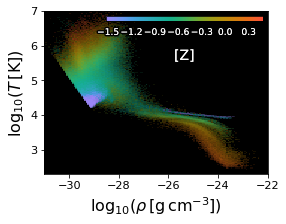

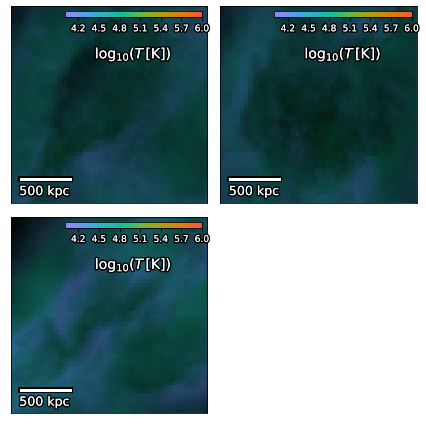

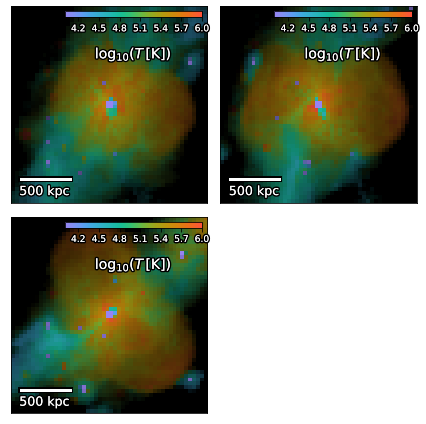

In [25]:
pg.environment.verbose = pg.environment.VERBOSE_QUIET

# some pressure threshold:
highP = pg.ExprMask("temp * rho * R / UnitScalar('1 g/mol') > '1e-18 N/m**2'")
# you can also do even more complex masking by combing masks:
lowPhighZ = (~highP) & pg.ExprMask("metallicity > 0.1*solar.Z()")
# or directly (note the parenthesis!):
#highPhighZ = pg.ExprMask("(temp * rho * R / UnitScalar('1 g/mol') "
#                         "> '1e-18 N/m**2') & (metallicity > 0.1*solar.Z())")

# use the high pressure mask
mask = highP

fig, ax = plt.subplots(figsize=(4,3))
pg.plotting.phase_diagram(s.gas[mask], rho_units='g/cm**3',
                          extent=[[-31,-22],[2.3,7]],
                          colors='metallicity/solar.Z()', colors_av='mass',
                          clim=[3e-2,0.3e1], clogscale=True,
                          showcbar=True, cbartitle=r'[Z]',
                          ax=ax);

print('masked fraction for ...')
print('   all gas:      %4.1f%%' % (
    1e2 * s.gas[mask]['mass'].sum() / s.gas['mass'].sum()))
print('   gas in ball:  %4.1f%%' % (
    1e2 * ball.gas[mask]['mass'].sum() / ball.gas['mass'].sum()))

# Move entire simulation (for easier plotting); explained in more detail later
ball_center = pg.UnitArr([48.072,49.346,46.075],'Mpc')
pg.Translation(-ball_center).apply(s)

for mask in [~mask, mask]:
    fig,ax = plt.subplots(2,2, figsize=(6,6))
    args = dict(extent='2 Mpc', vlim=[3e3,1e6], clim=[1e4,1e6], Npx=50)#100)
    pg.plotting.image(s.gas[mask], xaxis=0, yaxis=1, ax=ax[0,0], **args);
    pg.plotting.image(s.gas[mask], xaxis=0, yaxis=2, ax=ax[1,0], **args);
    pg.plotting.image(s.gas[mask], xaxis=2, yaxis=1, ax=ax[0,1], **args);
    ax=ax[1,1].set_axis_off()
    fig.tight_layout()

pg.Translation(ball_center).apply(s)
pg.environment.verbose = pg.environment.VERBOSE_NORMAL

### 1.5 dervied blocks

There are also some blocks additional to the blocks from the snapshot file. These are so-called "derived blocks" that are calculated from other blocks (as defined in the `derived.cfg`) and automatically updated, if the underlying data changes (with lazy evaluation, i.e. they are only (re-)calculated when needed).

A example for such an derived block are the particle radii (distance form origin):

In [26]:
s['r']

derive block r... done.


SimArr([82877.3958461 , 82876.95439789, 82877.14966081, ...,
        82878.50431205, 82877.75672463, 82877.42412384],
       units="kpc", snap="snap_M1196_4x_470")

In [27]:
print(s['r'][0])
# if no units are given, the ones of the UnitArr are taken,
# meaning we substract [1e4,1e4,1e4]*s.pos.units
s['pos'] -= [1e4,1e4,1e4]
print(s['r'][0])
s['pos'] += [1e4,1e4,1e4]
print(s['r'][0])

82877.39584609753
derive block r... done.
65565.47220152174
derive block r... done.
82877.39584609753


The caching of the derived blocks, of course, needs some memory. It, however, can be turned off. Some blocks with time-consuming calculation can still be cached though (list is specified in the config file `derived.cfg`):

In [28]:
s.cache_derived = False
s.always_cached_derived

['jcirc', 'angmom', 'Ekin', 'temp', 'age', 'LX']

In [29]:
del s['r']
s['r']
s['r']
s.cache_derived = True

derive block r... done.
derive block r... done.


### 1.6 more on blocks and `UnitArr`s

Blocks that get deleted can always be re-loaded / re-derived by simply accessing them as shown above. The only exception are custom blocks you added yourself:

In [30]:
s['custom'] = np.ones(len(s))
s['custom']

SimArr([1., 1., 1., ..., 1., 1., 1.], snap="snap_M1196_4x_470")

In [31]:
del s['custom']
try:
    s['custom']
except KeyError as e:
    print("KeyError:", e)

KeyError: '(Sub-)Snapshot <Snap "snap_M1196_4x_470"; N=2,079,055; z=0.000> has no block "custom".'


You can get new blocks calculated from existing ones with the method `get` (not that this one makes much sense...):

In [32]:
s.gas.get('log10(temp) * mass')

SimArr([2356062.3306327 , 3844921.07874862, 2844344.12822243, ...,
        3343329.18539848, 3272203.70287033, 3338644.58370431],
       units="Msol", snap="snap_M1196_4x_470":gas)

When calculating with blocks, they get converted if necessary:

In [33]:
pg.UnitArr([1,2,3],'km/h')  +  pg.UnitArr([1.2,1.3,1.4],'m/s')

UnitArr([5.32, 6.68, 8.04], units="h**-1 km")

If units contain cosmological parameter such as the scale parameter in comoving units, you need to specify them by `subs`(titutions). This can either be a `dict` or a snapshot instance:

In [34]:
pg.UnitArr([1.23, 4.56],'ckpc/h_0') .in_units_of('kpc', subs={'a':0.5, 'h_0':0.7})

UnitArr([0.87857143, 3.25714286], units="kpc")

In [35]:
pg.UnitArr([1.23, 4.56],'ckpc/h_0') .in_units_of('kpc', subs=s)

UnitArr([1.70833333, 6.33333333], units="kpc")

You can ensure to have a `UnitArr` rather than a simple `list` of a `np.ndarray` with `UnitQty` and at the same time ensure certain units and `dtype`:

In [36]:
pg.UnitQty([1,2,3], 'kpc')

UnitArr([1, 2, 3], units="kpc")

In [37]:
pg.UnitQty(pg.UnitArr([1,2,3], 'kpc'), 'Mpc', dtype=float)

UnitArr([0.001, 0.002, 0.003], units="Mpc")

Similar is `UnitScalar` that additionally ensure that the result is a scalar:

In [38]:
pg.UnitScalar('1.2 kpc/Mpc')

UnitArr(1.2, units="Mpc**-1 kpc")

And these can be converted into floats with proper conversion into dimensionless units, if possible:

In [39]:
float( pg.UnitScalar('1.2 kpc/Mpc') )

0.0012

**caveat:** if the units cannot be converted to dimensionless ones, they are simply cut off. Hence, it is

In [40]:
float( pg.UnitScalar('1.2 Msol kpc/Mpc') )

1.2

## 2. analysis and plotting

Let us first make `pygad` less talky:

In [41]:
pg.environment.verbose = pg.environment.VERBOSE_TACITURN

## 2.1 a first look

There is a very general plotting function in `pygad`. If it is not specified what to plot, it automatically chooses these plotting quantities from the type of the sub-snapshot passed.

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.colorbar.ColorbarBase at 0x7f4acd5f21c0>)

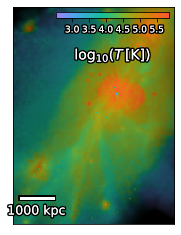

In [42]:
pg.plotting.image(s.gas)

Here, the luminance of the image scales with the logarithm of the column density and the color is (density-weighted) temperature as indicated by the colorbar. The extent of the plot is chosen such that most of the particle are within the plotted region. We are here apparently dealing with a zoomed-in simulation.

The smoothing of the SPH particles is always properly taken into account and the mapping is integral conserving (which is not true for all the plotting routines out there!).

More on plotting follows below. Still, I want to emphasise again that every function (and class) in `pygad` is documented! So use `help(pygad.plotting.image)`.

## 2.2 finding halos & preparing a zoom

In galaxy formation simulations we typically what to identify halos and galaxies and then do analysis on them. If we know all particle IDs of a halo or galaxy (e.g. taken from a halo finder), we could just use `pygad.IDMask` for masking out the structure of interest as a sub-snapshot and then use the machinery of `pygad` (or self-written tools building on `pygad`).

### 2.2.1 shrinking sphere

However, `pygad` offers a few tools for identifying halos and galaxies. One simple approach in a zoomed-in simulation (as the one used here) is the shrinking sphere method:

In [43]:
center = pg.analysis.shrinking_sphere(s.stars, center=[s.boxsize/2]*3, R=s.boxsize)

... and then just do a translation of the entire snapshot:

In [44]:
pg.Translation(-center).apply(s)
print(center)

[48072.26230568 49346.29251456 46074.8201634 ] [kpc]


This way of doing the translation has the advantage that the snapshot stores the action and applies the translation to the positions each time they are reloaded:

In [45]:
pg.environment.verbose = pg.environment.VERBOSE_TALKY
del s['pos']
s['pos'];
pg.environment.verbose = pg.environment.VERBOSE_TACITURN

load block "POS " as pos... done.
convert to double precision... done.
convert block pos to physical units... done.
apply stored Translation to block pos... done.


There are some more such transformations (as a rotation) in `pygad.transformation`.

### 2.2.2 `pygad`'s FoF finder

`pygad` also offers a friends-of-friends (FoF) finder for identifiying halos. In fact, it is more than just a simple FoF finder, since one can also specify a maximum velocity difference for particles becoming "friends".

In [46]:
# by default the velocity criterion is not used
FoF, N_FoF = pg.analysis.find_FoF_groups(s.dm, l='6 ckpc')

Note how the most massive dark matter halo, indeed is roughly at the center found by the shrinking sphere (though it was on stars not dark matter).

`FoF` is a array with halo indices sorted by mass (`pygad.analysis.NO_FOF_GROUP_ID` for particles without a halo). So the group with ID 0 is the most massive one. That could now be used for masking:

In [47]:
halo = s.dm[FoF==0]
halo['mass'].sum()

UnitArr(8.850630e+11, units="Msol")

More convenient is, however, can be using `pygad.analysis.generate_FoF_catalogue` which returns a list of `Halo` classes. These have the advantage to have some basic properties, such as total mass, center of mass, and virial radius, and they can be used to mask the halos by IDs so that you don't have to mask excalty the sub-snapshot you passed to `pygad.analysis.find_FoF_groups`. The downside is that calculating the halo properties takes some time, which, however, can be reduced by limiting the catalogue to only the most massive ones by setting `max_halos`. Additionally, one can excluding some for which a function of halo and snapshot passed as `exclude` returns `True`.

In [48]:
halos = pg.analysis.generate_FoF_catalogue(s.dm, FoF=FoF, max_halos=5,
                                           exlude=lambda h,s:
                                               h.lowres_mass/h.mass > 0.01)

Passing `FoF` can be omitted, then `generate_FoF_catalogue` calls `find_FoF_groups` itself.

In [49]:
halo = halos[0]
halo.props

{'mass': UnitArr(8.850630e+11, units="Msol"),
 'Mstars': UnitArr(0.000000e+00, units="Msol"),
 'Mgas': UnitArr(0.000000e+00, units="Msol"),
 'Mdm': UnitArr(8.850630e+11, units="Msol"),
 'parts': (0, 244655, 0, 0, 0, 0),
 'com': UnitArr([ 0.16575065, -4.25056617,  2.18615717], units="kpc"),
 'ssc': UnitArr([ 0.2810971 , -0.37346074,  0.32740605], units="kpc"),
 'vel': UnitArr([ -46.49908121,  -13.45295948, -111.41832091], units="km s**-1"),
 'vel_sigma': UnitArr(190.13228766361377, units="km s**-1"),
 'Rmax': UnitArr(245.35283145407905, units="kpc"),
 'lowres_part': 0,
 'lowres_mass': UnitArr(0.000000e+00, units="Msol"),
 'avg_gas_temp': UnitArr([], dtype=float64, units="K"),
 'rho_gas_avg': UnitArr([], dtype=float64, units="Msol kpc**-3"),
 'mean_stellar_age': nan,
 'gas_half_mass_radius_from_com': UnitArr(0.000000e+00, units="kpc"),
 'gas_half_mass_radius_from_ssc': UnitArr(0.000000e+00, units="kpc"),
 'stars_half_mass_radius_from_com': nan,
 'stars_half_mass_radius_from_ssc': nan,
 '

The halo instances can be used to mask the snapshot to the sub-snapshots fo the halos:

In [50]:
h = s[halo]
h

<Snap "snap_M1196_4x_470":IDMask; N=244,655; z=0.000>

... or using its properties to mask everying within $R_{200}$:

In [51]:
h = s[pg.BallMask(halo.R200_ssc, center=halo.ssc)]
print(h.parts)
print(h.dm['mass'].sum())

[51734, 274056, 0, 0, 66349, 0]
9.914239e+11 [Msol]


The velocity criterion can be handy for definig the galaxy:

In [52]:
pg.environment.verbose = pg.environment.VERBOSE_NORMAL
galaxies = pg.analysis.generate_FoF_catalogue(
    s.baryons, l='6 ckpc', dvmax='100 km/s', max_halos=5)
pg.environment.verbose = pg.environment.VERBOSE_TACITURN

perform a FoF search on 1,001,472 particles:
  l      = 6 [kpc]
  dv_max = 1e+02 [km s**-1]
  N     >= 100
found 11 groups
the 3 most massive ones are:
  group 0:   5.09e+10 [Msol]  @  [1.25, -2.12, 1.57] [kpc]
  group 1:    9.7e+09 [Msol]  @  [1.07e+03, 2.08e+03, 924] [kpc]
  group 2:   5.88e+09 [Msol]  @  [750, 1.49e+03, 606] [kpc]
initialize halos  [#######.............................]  1/5load block form_time... done.
derive block age... done.
initialize halos  [####################################]  5/5
initialized 5 halos.


In [53]:
s[galaxies[0]]

<Snap "snap_M1196_4x_470":IDMask; N=88,926; z=0.000>

## 2.3 plotting maps and more

### 2.3.1 spatial maps

The main plotting function `pygad.plotting.image` automatically chooses colorbar and extent depending on what particle families are plotted. Alongside are the plotting quantities chosen. Generally this is column density. If only gas or stars are plotted the image is composed of two chanels, namely luminance for one quantity and color for another one. In case of the gas, the luminance is column denisty and color is density-weighted temperature. For stars only, the luminance is V-band luminosity (as from SSP models) and the color is V-band weighted age.

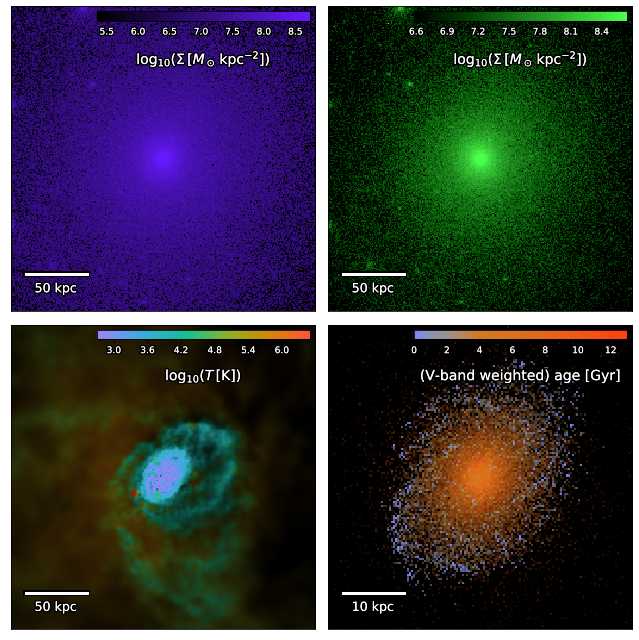

In [54]:
fig, ax = subplots(2,2, figsize=(9,9))
pg.plotting.image(s,       extent='250 kpc', ax=ax[0,0]);
pg.plotting.image(s.dm,    extent='250 kpc', ax=ax[0,1]);
pg.plotting.image(s.gas,   extent='250 kpc', ax=ax[1,0]);
pg.plotting.image(s.stars, extent= '50 kpc', ax=ax[1,1], Npx=150);
fig.tight_layout()

These are, however, only the defaults for `image`! The parameters can be adjusted by giving arguments to `image`.

Not that the colormap will be normed in luminosity, if both chanels, color (or more precisely) hue and luminosity, are used. It makes sense to choose a bright one. Note that not all colors can be equally bright (to the human eye). Pure blue ([0,0,1] in RGB space), for instance, is much darker than pure yellow ([1,1,0] in RGB space).

So for plotting with `image`:

* When combing the luminance and color information, use bright colormaps. I can recommend the newly defined `'Bright'` (similar to `'jet'` or `'rainbow'`, but brighter; often the default in `pygad` as for gas temperature), the also in `pygad` defined `'NoBlue[_r]'` or the standard `'PuOr_r'`, `'coolwarm'`, and `'spring'`. For some Python distributions there is also `'plasma'` and `'viridis'`.
* If you want to have such a combination of luminance channel and color chanel, specify both, `qty` and `colors`. If you only pass a `qty` to plot, it is plotted using the given colormap and the luminance is not used.
* Both, `qty` and `colors` can be averaged by some other quantity given by `av` or `colors_av`, respectively.
* You can define the axis / orientation by `xaxis` and `yaxis`.
* By default a surface density is plotted. This means, if you set `qty='mass'`, actually the column density is plotted. To plot the quantity summed along the line of sight (or averaged, if `av` is given) set `surface_dens=False`. * You can set to plot in log-scale. If you set something like `qty='log10(temp)'`, note that already the given quantity is logarithmic. Don't forget to adjust the limits accordingly!
* Extent and resolution of the map can be specified independently for the two directions.

**Example:** a more complicated plotting example including some simple masking:

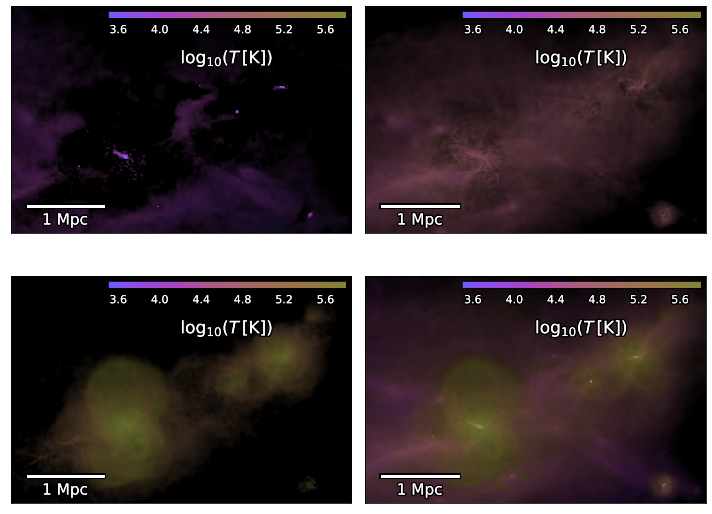

In [55]:
args = dict(
    extent       = pg.UnitArr([[-1.5,3.0],[-1.0,2.0]], 'Mpc'),
    Npx          = [4*90,4*60],
    qty          = 'mass',                   av        = None,
    field        = False,                    surface_dens = True,
    units        = 'Msol/kpc**2',            vlim      = [2e3,2e6],
    colors       = 'temp',                   colors_av = 'mass',
    clogscale    = True,                     cbartitle = r'$\log_{10}(T\,[\mathrm{K}])$',
    clim         = [10.**3.5,10.**5.8],
    cmap         = 'plasma',                 desat     = 0.33,
    xaxis        = 1,                        yaxis     = 2,
    scaleunits   = 'Mpc',
    fontcolor    = 'w',                      fontsize  = 17,
)

# simple boolean masks
cold =  s.gas['temp'] < '2e4 K'
warm = (s.gas['temp'] < '1e5 K') & ~cold
hot  =  s.gas['temp'] >= '1e5 K'

fig, ax = subplots(2,2, figsize=(10,8))
fig, ax0, im0, cbar0 = pg.plotting.image(s.gas[cold],  ax=ax[0,0], **args);
fig, ax1, im1, cbar1 = pg.plotting.image(s.gas[warm],  ax=ax[0,1], **args);
fig, ax2, im2, cbar2 = pg.plotting.image(s.gas[hot],   ax=ax[1,0], **args);
fig, ax2, im2, cbar2 = pg.plotting.image(s.gas,        ax=ax[1,1], **args);
fig.tight_layout()

del cold, warm, hot

Explain `field` and `surface_density`:

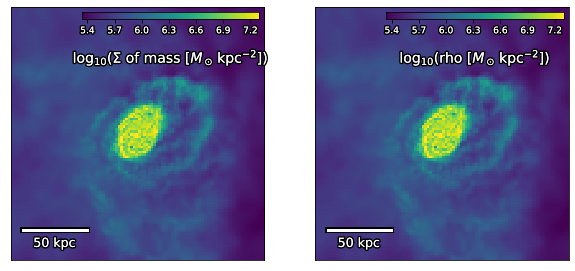

In [56]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
pg.plotting.image(s.gas, extent='200 kpc', Npx=100, qty='mass', field=False, surface_dens=True, ax=axs[0])
pg.plotting.image(s.gas, extent='200 kpc', Npx=100, qty='rho', ax=axs[1])
plt.show()

As already mentioned, SPH smoothing is always correctly taken into account. It is also ensured that no particles "fall through the grid" and the resulting map is integral conserving. That is, if you plot mass (as a surface density) the integral over the map is the total mass in the map. A naive binning technique where the SPH density is evaluated at each pixel center would not give such a map!

It follows an example plotting stellar quantities. As those are point particles, one ends up with a very grainy map, if the resolution is high. They, however, can also be smoothed by a softening length when passed to the plotting function by the argument `softening`.

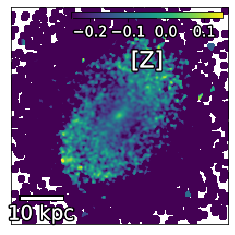

In [57]:
fig, ax, im, cbar = pg.plotting.image(s.stars, extent='55 kpc', Npx=200,
                                      qty='metallicity/solar.Z()', av='mass',
                                      surface_dens=False,
                                      vlim=[10**-0.25, 10**0.15],
                                      softening=pg.UnitArr([0,2,5,10,1,1], 'kpc'),
                                      fontcolor='w', fontsize=22,
                                      cbartitle='[Z]');
cbar.set_ticks([-.2, -.1, 0, .1,])

### 2.3.2 on the color-coding

Tell about why 'jet' is bad and shortly about color-spaces (rgb vs. hsv and human perception).

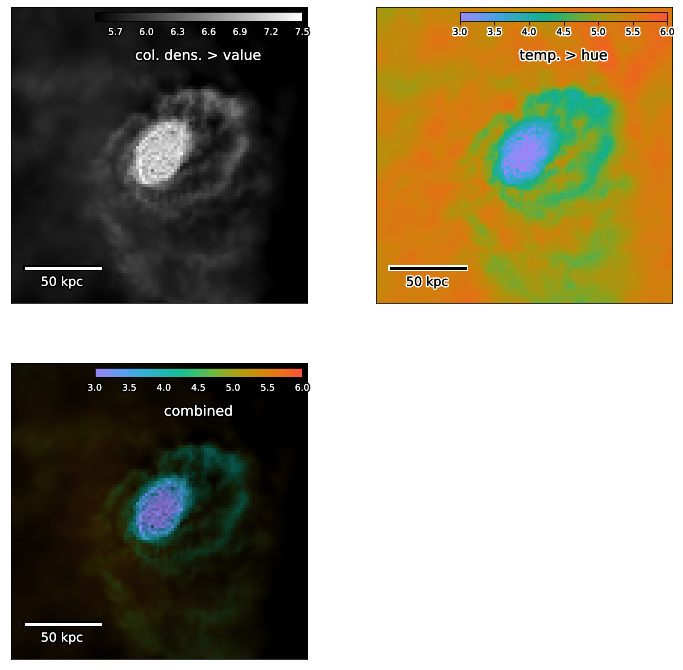

In [58]:
fig, axs = plt.subplots(2,2, figsize=(12,12))
pg.plotting.image(s.gas, extent='200 kpc', Npx=100, qty='rho', vlim=[10**5.5,10**7.5],
                  cmap='gray', cbartitle='col. dens. > value', ax=axs[0,0])
pg.plotting.image(s.gas, extent='200 kpc', Npx=100, qty='log10(temp)',
                  av='rho', surface_dens=False, units=1, vlim=[3,6], logscale=False,
                  cmap='isolum', cbartitle='temp. > hue', fontcolor='k', ax=axs[0,1])
pg.plotting.image(s.gas, extent='200 kpc', Npx=100, qty='rho', vlim=[10**5.5,10**7.5],
                  colors='log10(temp)', colors_av='rho', csurf_dens=False, cunits=1, clim=[3,6],
                  cmap='isolum', cbartitle='combined', ax=axs[1,0])
axs[1,1].axis('off');

### 2.3.3 plotting slices (of finite thickness)

SPH binnning routines in pygad ensure that nothing "falls through the grid" by normalising the contribution of each particle by the discrete integral of its kernel over the grid. Whenever this is happens to be zero (the particle falls through the grid entirely), the particle is fully added to the closes cell. This can, of course, only be applied to particles that are entirely within in the grid.

Here we create a 1 kpc thick slice, padding with a few additional voxels/cells to make use of the normation described in order to not let anything fall through the grid.

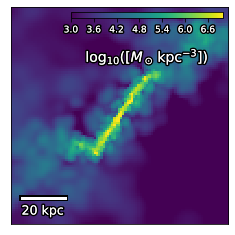

In [59]:
m = pg.binning.SPH_to_3Dgrid(s.gas, 'rho', extent=pg.UnitArr([100,100,11],'kpc'), Npx=[100,100,11])
pg.plotting.plot_map(m[:,:,5], vlim=[1e3,1e7]);

Let us zoom in a bit and plot linearly to see the differences between the normation in pygad and what it looks like without:

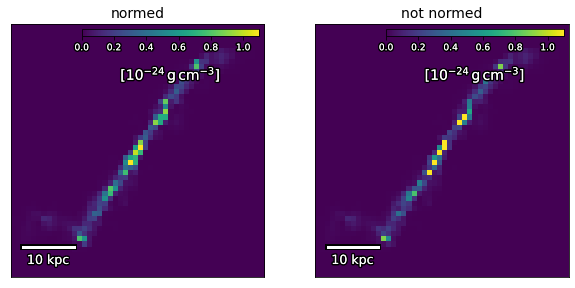

In [60]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

pltargs = dict(units='1e-24 g/cm**3', vlim=[0,1.1], logscale=False)

for ax, normed in zip(axs,[True,False]):
    m = pg.binning.SPH_to_3Dgrid(s.gas, 'rho', extent=pg.UnitArr([50,50,11],'kpc'), Npx=[50,50,11], normed=normed)
    pg.plotting.plot_map(m[:,:,5], ax=ax, **pltargs);
    ax.set_title(('' if normed else 'not ') + 'normed', fontsize=14)

density weigthed temperature (as the simulation is a multi-phase one and one would otherwise overshadow any small temperature as they vary over orders of magnitude):

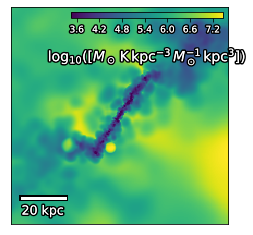

In [61]:
m = pg.binning.SPH_to_3Dgrid(s.gas, 'rho*temp', extent=pg.UnitArr([100,100,5.5],'kpc'), Npx=[200,200,11])
m /= pg.binning.SPH_to_3Dgrid(s.gas, 'rho', extent=pg.UnitArr([100,100,5.5],'kpc'), Npx=[200,200,11])
pg.plotting.plot_map(m[:,:,5]);

### 2.3.4 plot vector fields

For overplotting maps with vector fields, you can use `pg.plotting.vec_field`, which uses either `plt.quiver` or `plt.streamplot` (depending on the argument `streamplot`) to plot the vecot field. Please, also read the documentation of `matplotlib` on these functions!

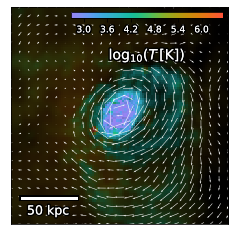

In [62]:
fig, ax = plt.subplots()
pg.plotting.image(s.gas, extent='200 kpc', Npx=100, ax=ax)
pg.plotting.vec_field(s.gas, 'vel', av='mass', color='w',
                      extent='200 kpc', Npx=25, ax=ax,
                      angles='xy', units='xy', scale_units='xy', scale=10., # passed to plt.quiver
                     )
plt.show()

### 2.3.5 maps in other spaces

Although a phase diagram is not a map in the sense that the coordinates of the plot are spatial postions it is a map. Te procedure of plotting is very similar. Here is a phase diagram colorcoded by mass-weighted metallicity (`u` is the atomic mass unit):

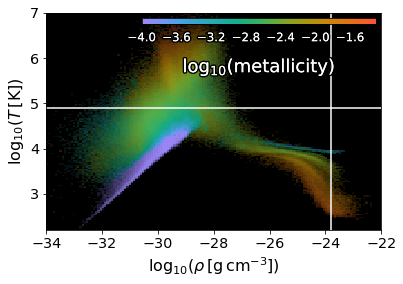

In [63]:
pg.plotting.phase_diagram(s.gas, rho_units='g/cm**3', extent=[[-34,-22],[2.2,7]],
                          colors='metallicity', colors_av='mass',
                          clogscale=True, clim=[1e-4, 5e-2],
                          fontcolor='w', fontsize=18, showcbar=True,
                          threshold_col='w',
                          T_threshold='8e4 K', rho_threshold='1 u/cm**3');

A more general routine to produce such a 2D-histogram like plot is `pygad.plotting.scatter_map`. It basically is a genearl plotting function for 2D histograms:

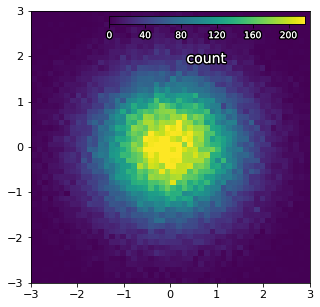

In [64]:
fig, ax = subplots(figsize=(5,5))
pg.plotting.scatter_map(np.random.normal(size=int(1e5)),
                        np.random.normal(size=int(1e5)),
                        extent=[[-3,3],[-3,3]], fontcolor='w',
                        bins=50, ax=ax);

... but with added functionality, especially for snapshots:

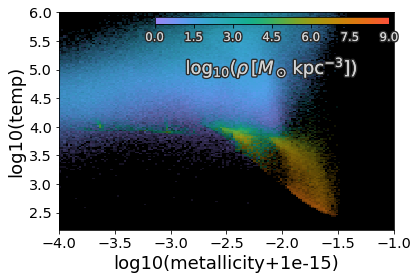

In [65]:
pg.plotting.scatter_map('log10(metallicity+1e-15)', 'log10(temp)', s.gas, bins=150,
                        logscale=True, extent=[[-4,-1],[2.2,6]],
                        colors='log10(rho)', colors_av=np.ones(len(s.gas)),
                        cbartitle=r'$\log_{10}(\rho\,[%s])$'%s.gas['rho'].units.latex(),
                        clim=[0,9], fontcolor='lightgray', fontsize=18);

### 2.3.6 plotting profiles

`pygad` also provides plotting routines for profiles of arbitrary quantities in either 3D or projected along one coordinate axis. As an example, I plot (face-on) surface densities of stars and gas.

*Note* that in the version of `pygad` used here, the SPH smoothing is not taken into account.

In [66]:
pg.__version__

'0.9.10'

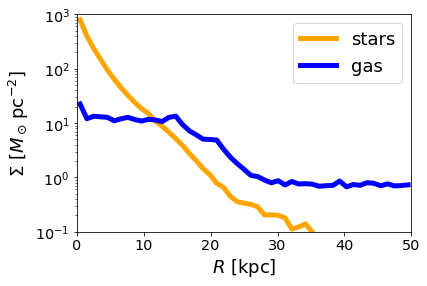

In [67]:
fig, ax = pg.plotting.profile(s.stars, Rmax='50 kpc', qty='mass', proj=2,
                              units='Msol/pc**2', linewidth=5,
                              color='orange', label='stars');
pg.plotting.profile(s.gas, Rmax='50 kpc', qty='mass', proj=2,
                    units='Msol/pc**2', linewidth=5, color='blue',
                    ax=ax, label='gas', labelsize=18);
ylim([1e-1, 1e3]);
xlim([0, 50]);
legend(fontsize=18);

# TODO from 3D grids...

... also implement in `pygad`

In [68]:
m = pg.binning.SPH_to_3Dgrid(s.gas, 'rho', extent='100 kpc', Npx=200)

## 2.4 binning

The plotting routine `image` heavily depens on two fundamental binning routines for SPH properties. One bins onto a 3D grid (`pygad.binning.SPH_to_3Dgrid`) and the other one onto a projected 2D map (`pygad.binning.SPH_to_2Dgrid`). The latter is almost a factor of 100 faster than first binning onto a 3D grid and then project and needs more than a factor of 100 less memory for typical situations where the 3D grid would have several 100 pixels in depth.

The 3D version works similar to the 2D one. Therefore, I demonstrate only the use of the projected version here:

In [69]:
map2D = pg.binning.SPH_to_2Dgrid(s.gas, 'rho', extent='100 kpc', Npx=100)
map2D.res()

UnitArr([1., 1.], units="kpc")

In [70]:
map2D

<Map at 0x7f4acd656e40; units="Msol kpc**-2", Npx=(100, 100)>

In [71]:
map2D.grid

UnitArr([[551685.07588985, 558177.50074106, 565651.6425691 , ...,
          675352.34115483, 672358.3685192 , 678023.2944989 ],
         [547319.50046793, 554477.91990415, 563318.12853732, ...,
          690608.64125189, 685518.25308419, 690098.11697906],
         [542531.23614675, 549947.81096442, 559733.28868866, ...,
          706404.20297724, 701565.28894249, 705666.21541794],
         ...,
         [514280.10449838, 481333.67487301, 472074.0752207 , ...,
          435766.00426641, 456159.46257423, 471661.54486868],
         [538476.75293882, 499425.87627595, 490818.29890022, ...,
          423073.68966919, 442946.20685275, 457666.88943816],
         [548151.28476983, 509324.6854588 , 501672.59929255, ...,
          406980.53409107, 424798.49871944, 437250.22514368]],
        units="Msol kpc**-2")

Also the quantitative profile as intermediate step for plotting profiles can be accessed directly. There is `radially_binned` and `profile_dens` in `pygad.analysis`.

## 2.5 quantitative analysis

### 2.5.1 defining discs

Colorful maps are neat and can help to understand the simulations, but in the end we are physicists and want quantitative results. Only a few of the analysis functions presented so far are of such type. There is, of course, more to that in `pygad`. Let us start by orientating our simulation at the "reduced inertia tensor" (Raini & Steinmetz, 2005) of the galaxy after centering it in coordinate and velocity space:

In [72]:
g = s.baryons[pg.BallMask(0.15*halo.R200_com)]

center = pg.analysis.center_of_mass(g)
pg.Translation(-center).apply(s)

vel_center = pg.analysis.mass_weighted_mean(g[pg.BallMask('1 kpc')], 'vel')
s['vel'] -= vel_center

# using `transformation.Rotation` in the backend
pg.analysis.orientate_at(g, 'L', total=True)

Giving `total=True` lets the entire snapshot orientate, not just the passed sub-snapshot. Once orientated, we can decompose the galaxy into its disc and the rest of the galaxy using a predefined mask of `pygad`:

In [73]:
disc_mask = pg.DiscMask(jzjc_min=0.85, rmax=None, zmax='3 kpc')
disc    = g[ disc_mask]
nondisc = g[~disc_mask] # all masks in pygad can be inverted with ~

The main criterion to differentiate between the disc and the rest in `DiscMask` is the parameter `jzjc`, the ratio between the z-component of the angular momentum $j_z$ of an particle and the angular momentum $j_c$ of an particle with the same energy but on a circular orbit:

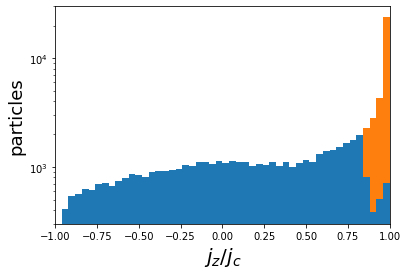

In [74]:
hist([nondisc['jzjc'], disc['jzjc']],
     bins=50, range=(-1,1),
     histtype='stepfilled', stacked=True, log=True);
xlim([-1,1])
ylim([3e2, 3e4])
ylabel('particles', fontsize=18);
xlabel('$j_z / j_c$', fontsize=20);

A plot to demonstrate the power of the decomposition:

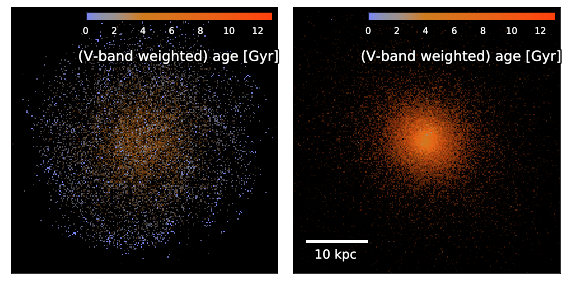

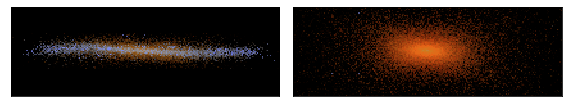

In [75]:
fig, ax = subplots(1,2, figsize=(8,4))
pg.plotting.image(disc.stars,    extent='45 kpc', Npx=210, ax=ax[0], scaleind=None);
pg.plotting.image(nondisc.stars, extent='45 kpc', Npx=210, ax=ax[1]);
fig.tight_layout()

fig, ax = subplots(1,2, figsize=(8,1.8))
pg.plotting.image(disc.stars,    extent=pg.UnitArr([45,15], 'kpc'),
                  Npx=[210,70], yaxis=2, ax=ax[0],
                  showcbar=False, scaleind=None);
pg.plotting.image(nondisc.stars, extent=pg.UnitArr([45,15], 'kpc'),
                  Npx=[210,70], yaxis=2, ax=ax[1],
                  showcbar=False, scaleind=None);
fig.tight_layout()

We now can calculate kinematical disc-to-total mass and luminosity ratios of the stars:

In [76]:
float( disc.stars['mass'].sum() / g.stars['mass'].sum() )

0.29713162756942085

In [77]:
float( disc.stars['lum'].sum() / g.stars['lum'].sum() )

0.718517497098701

In [78]:
float( disc.stars['lum_v'].sum() / g.stars['lum_v'].sum() )

0.5954898632538318

Using numpy we can calculate median ages of the disc and the rest. As already seen from the maps, the disc is much younger:

In [79]:
print('disc:', np.median( disc.stars['age'] ))
print('rest:', np.median( nondisc.stars['age'] ))

disc: 3.4274037593732345 [Gyr]
rest: 10.32097668960518 [Gyr]


Or as a diagram:

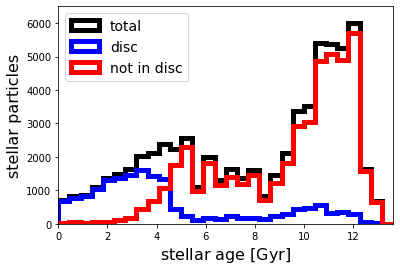

In [80]:
hist([nondisc.stars['age'], disc.stars['age'], g.stars['age']],
     label=('not in disc', 'disc', 'total'),
     color=('r', 'b', 'k'),
     bins=30, range=(0,s.cosmology.universe_age()),
     histtype='step', stacked=False, linewidth=5);
xlim([0, s.cosmology.universe_age()])
ylim([0, 6.5e3])
ylabel('stellar particles', fontsize=16);
xlabel('stellar age $[%s]$' % disc.stars['age'].units.latex(), fontsize=16);
legend(loc='upper left', fontsize=14);

### 2.5.2 half-mass and half-light radii

Often half-mass and/or effective radii are of interest. `pygad` can calculate them in either 3D or projections along one of the three coordinate axis:

In [81]:
pg.analysis.half_mass_radius(g.stars, proj=None) # 3D half-mass radius

UnitArr(5.41335826344117, units="kpc")

In [82]:
pg.analysis.half_mass_radius(g.stars, proj=2)

UnitArr(5.128493851690233, units="kpc")

The effective radius can be calculate in any band using the single stellar population (SSP) models of Bruzual & Charlot (however, no gas and dust extinction is included):

In [83]:
pg.analysis.eff_radius(g.stars, band='V', proj=2)

UnitArr(7.8312336844308135, units="kpc")

And half-quantity radii can also be calculated of arbitrary other quantities:

In [84]:
pg.analysis.half_qty_radius(g.stars, 'metals', proj=2)

UnitArr(4.788596716602991, units="kpc")

### 2.5.3 virial radius and mass

Given the center of some halo, `virial_info` calculates the "virial" radius and "virial" mass in terms of spherical overdensity thresholds you can define. By default it is $R_{200}$ and $M_{200}$.

In [85]:
pg.analysis.virial_info(s)

(UnitArr(207.99153123127675, units="kpc"), UnitArr(1.084189e+12, units="Msol"))

In [86]:
pg.analysis.virial_info(s, odens=500, center=[0]*3)

(UnitArr(141.493027952519, units="kpc"), UnitArr(8.533249e+11, units="Msol"))

### 2.5.4 ionisation states & mock absoprtion spectra

I also want to draw some attention to the sub-module `pygad.analysis.absorption_spectra` and the derived blocks for ion masses.

Let's define some line of sights (l.o.s.) along given coordinate axis and a line to look at. Line properties for some chosen ones are predefined in `pygad.analysis.absorption_spectra.lines`.

In [87]:
loss = pg.UnitArr([[  50.,  100.],
                   [-180., -100.],
                   [ 170., -150.],
                   [-110.,   10.],
                   [ -45.,    5.],
                   [  48.,  -20.],
                   [ 250., -200.]], 'kpc')
xaxis, yaxis, zaxis = 0, 2, 1
line_name = 'Lyman_alpha'
line = pg.analysis.absorption_spectra.lines[line_name]
for key, value in line.items():
    print('%-10s %s' % (key+':', value))

ion:       HI
l:         1215.6701 Angstrom
f:         0.4164
atomwt:    1.00794 [u]
A_ki:      4.6986e+08 s**-1
element:   H


In [88]:
print(len(pg.analysis.absorption_spectra.lines), ', '.join(list(pg.analysis.absorption_spectra.lines.keys())))

40 H1215, H1025, H972, HeII, CII1036, CII1334, CII1335, CIII977, CIV1548, CIV1550, NI1199, NI1200, NI1201, NII1083, NV1238, NV1242, OI1302, OI1304, OI1306, OIV787, OVI1031, OVI1037, NeVIII770, MgII2796, SiII1190, SiII1193, SiII1260, SiIII1206, SiIV1393, SiIV1402, SI1295, SI1425, SI1473, SII1250, SII1253, SII1259, SIII1190, Lyman_alpha, Lyman_beta, Lyman_gamma


The line properties are influenced by some gas properties: most and formost the column density, of course, but also the l.o.s. velocity and its dispersion (or actually the precise distribution) and the (ion) temperature. So let's plot some maps with the line positions indicated:

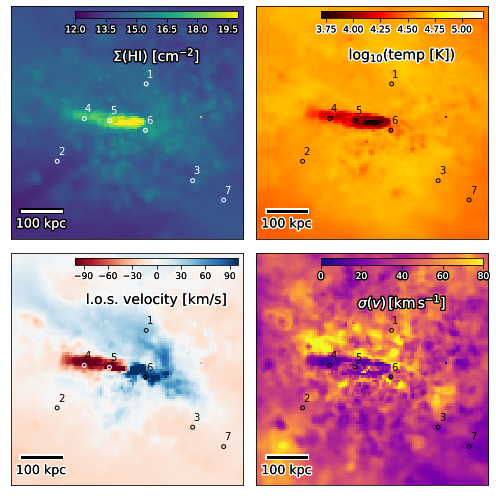

In [89]:
fig, axs = plt.subplots(2, 2, figsize=(7,7))
d = 300.
pltargs = dict(
    extent = pg.UnitArr([[-d,d],[-d,d]],'kpc'),
    xaxis = xaxis, yaxis = yaxis,
    Npx = 100,
)

units = pg.UnitArr(line['atomwt']) * pg.Unit('cm**-2')
units = float(units) * units.units

pg.plotting.image(s.gas, line['ion'],
                  field=False, surface_dens=True,
                  units=units, vlim=[1e12,1e20],
                  cbartitle=r'$\Sigma$(%s) [$%s$]' % (
                      line['ion'], pg.Unit('cm**-2').latex()),
                  ax=axs[0,0], **pltargs)

pg.plotting.image(s.gas, qty='temp', av=line['ion'],
                  surface_dens=False, units='K',
                  vlim=[10**3.7,10**5.2],
                  cmap='hot', fontcolor='k',
                  ax=axs[0,1], **pltargs)

pg.plotting.image(s.gas, qty='vel[:,%d]'%zaxis, av=line['ion'],
                  logscale=False, surface_dens=False,
                  units='km/s', vlim=[-100,100],
                  cbartitle='l.o.s. velocity [km/s]',
                  cmap='RdBu', fontcolor='k',
                  ax=axs[1,0], **pltargs)

# create a velocity dispersion plot
grid = pg.binning.SPH_to_2Dgrid_by_particle(s.gas, qty='vel[:,%d]'%zaxis,
                                            av=line['ion'],
                                            reduction='stddev', **pltargs)
vlim = pg.UnitArr( [0.,80.], grid.units)
cmap = 'plasma'
fig, ax, im = pg.plotting.show_image(grid, vlim=vlim,
                                     extent=pltargs['extent'],
                                     cmap=cmap, ax=axs[1,1])
pltargs.pop('Npx') # not a keyword in `make_scale_indicators`
pg.plotting.make_scale_indicators(ax, scaleind='line', outline=True, **pltargs)
pg.plotting.add_cbar(ax, cbartitle=r'$\sigma(v)\,[%s]$'%vlim.units.latex(),
                     clim=vlim, cmap=cmap, fontcolor='w', fontoutline=True)

fig.tight_layout()

for ax,c in zip( axs.flatten(), ['w','k','k','k'] ):
    for i,los in enumerate(loss):
        circle = plt.Circle(tuple(los), 5,
                            color='w' if (ax is axs[1,0] and i in [3,4]) else c,
                            fill=False)
        ax.add_artist(circle)
        ax.annotate(str(i+1), xy=los, xytext=(7,7), ha='right',
                    color=c, textcoords='offset points')




And now let's calculate the actual spectra and their equivalent widths (EW):

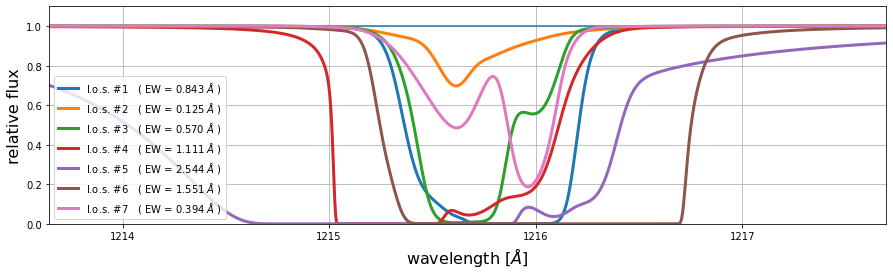

In [90]:
v_limits = pg.UnitArr([-500,500],'km/s')
fig, ax = subplots(figsize=(15,4))

for i,los in enumerate(loss):
    # we arenot using all of the calculated properties (see the documentation)
    tau, dens, temp, v_edges, _ = pg.analysis.mock_absorption_spectrum_of(
                s, los, line_name, v_limits,
                xaxis=xaxis, yaxis=yaxis,
                method='particles',
    )
    
    # v_edges are the edges of the bins in velocity space (rest frame velocity
    # that is) convert to observed wavelengths:
    z_edges = pg.analysis.velocities_to_redshifts(v_edges, z0=s.redshift)
    l_edges = pg.UnitScalar(line['l']) * (1.0 + z_edges)
    
    EW = pg.analysis.absorption_spectra.EW(tau,l_edges).in_units_of('Angstrom')
    x = (l_edges[:-1] + l_edges[1:]) / 2.0
    ax.plot(x, np.exp(-tau),
            label=r'l.o.s. #%d   ( EW = %.3f $%s$ )' % (
                i+1, float(EW), EW.units.latex()),
            linewidth=3)

ax.xaxis.set_major_locator( mpl.ticker.MultipleLocator(1.0) )
ax.xaxis.set_major_formatter( mpl.ticker.ScalarFormatter(useOffset=False) )
ax.grid(True)
ax.hlines(1.0, x.min(), x.max())
ax.set_xlim([x.min(), x.max()])
ax.set_ylim([0,1.1])
ax.set_xlabel(r'wavelength [$%s$]' % x.units.latex(), fontsize=16)
ax.set_ylabel(r'relative flux', fontsize=16)
ax.legend(loc='lower left');

### 2.6.5 ... and much more!

And there are much more functions for quantitative in `pygad.analysis`. For example:
1. NFW profile fitting (`NFW_fit`)
2. evaluating SPH fields on given postions (`SPH_qty_at` and `kernel_weighted`)
3. calculating X-ray luminosity (`x_ray_luminosity`)
4. calculating flow rates (`shell_flow_rates` and `flow_rates`)
5. global line-of-sight velocity dispersions `los_velocity_dispersion`
6. [...]

Go and explore!